# **BIBLIOTECAS**

In [ ]:
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 12.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import pandas as pd
import os
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import plotly.express as px
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from keras import models
from keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report, accuracy_score
from sklearn import tree
import shap
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

# **SANITY CHECK**
*   Entendimento inicial da base de dados
*   Identificar propriedades das colunas da base
*   Identificar possíveis inconsistências nos dados

In [ ]:
filename = "insurance.csv"
df = pd.read_csv(filename)
df.head(5)

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


In [ ]:
print(df.nunique())

age           47
sex            2
bmi          275
children       6
smoker         2
region         4
expenses    1337
dtype: int64


In [ ]:
print(df['sex'].unique())
print(df['smoker'].unique())
print(df['region'].unique())

['female' 'male']
['yes' 'no']
['southwest' 'southeast' 'northwest' 'northeast']


<font color='green'><b>Nota-se que quatro colunas são numéricas e três são categóricas.</b></font>

- <font color='green'><b>sex: ['female' 'male']</b></font>
- <font color='green'><b>smoker: ['yes' 'no']</b></font>
- <font color='green'><b>region: ['southwest' 'southeast' 'northwest' 'northeast']</b></font>


**Verificação de linhas brancas/nulas**

In [ ]:
np.where(df.map(lambda x: x == ''))

(array([], dtype=int64), array([], dtype=int64))

In [ ]:
null_rows = df[df.isna().any(axis=1)]
null_rows.shape

(0, 7)

<font color='green'><b>Não existem linhas vazias ou em branco.</b></font>


**Verificação de linhas duplicadas**

<font color='green'><b>Não é possível verificar linhas duplicadas, já que as linhas não possuem um identificador único.</b></font>

**Verificação de valores faltantes**

In [ ]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64


<font color='green'><b>Todas as colunas apresentam todas as linhas preenchidas totalmente.</b></font>

# **EDA**
*   Detalhar a caracterização das colunas, seus comportamentos e correlações
*   Identificar oportunidades de modelagem

In [ ]:
numerical_columns = ['age','bmi','children','expenses']
categorical_columns = ['sex', 'smoker', 'region']

## **Histograma das variáveis numéricas**


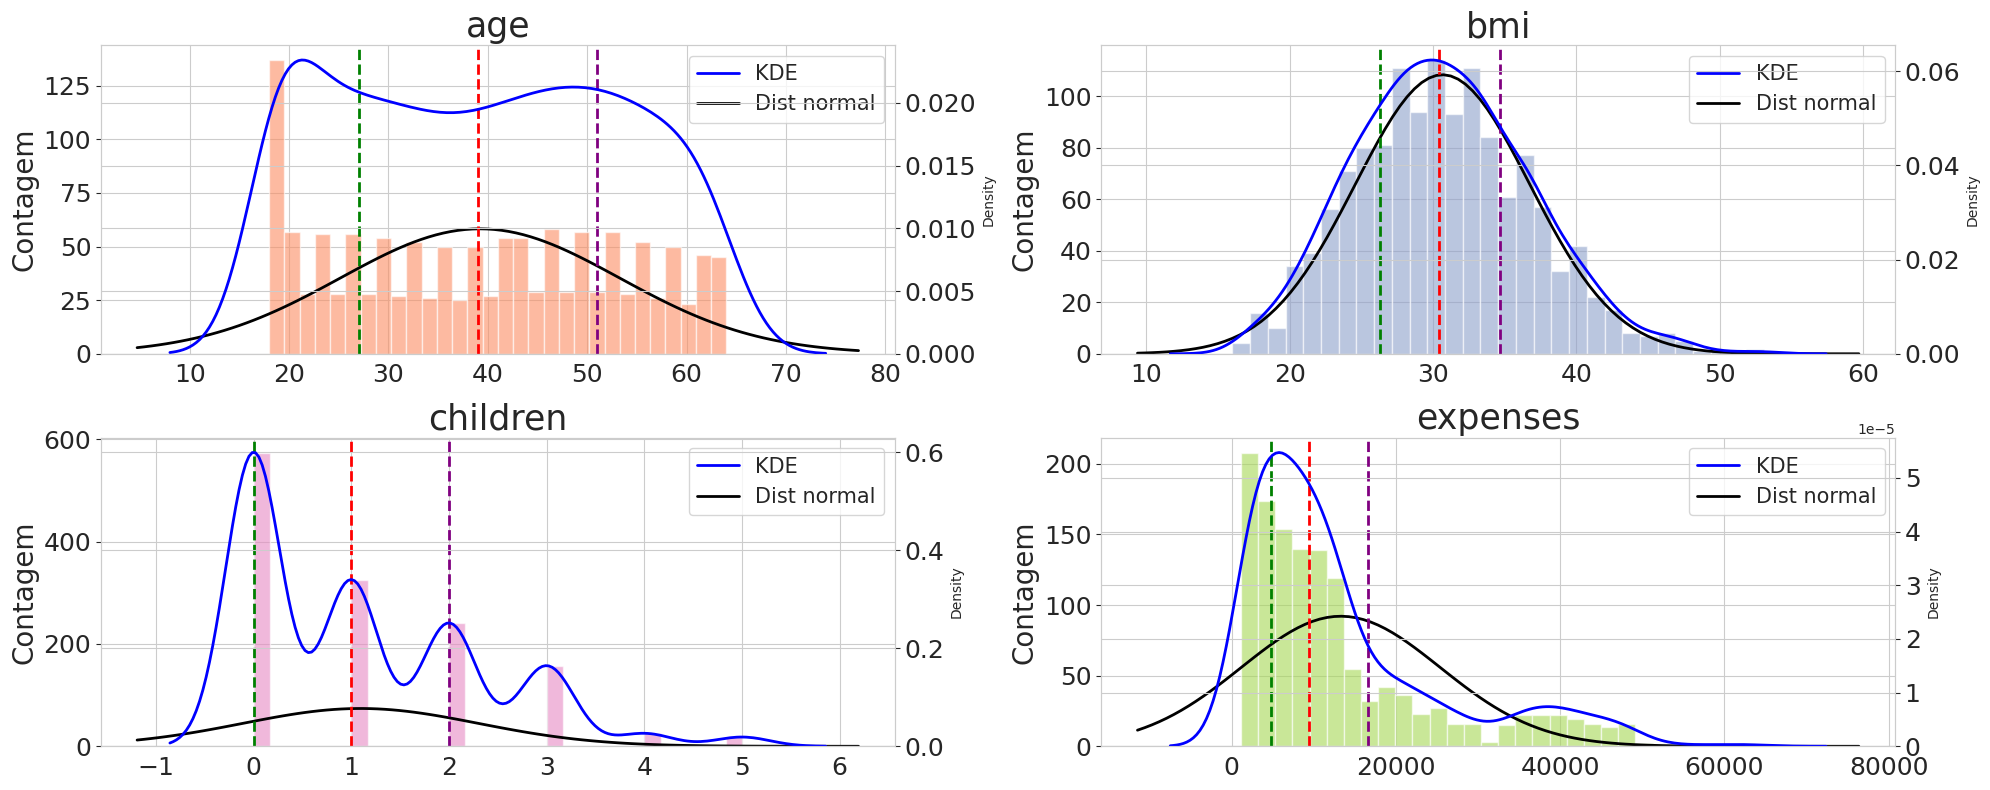

In [ ]:
sns.set_style("whitegrid")

num_cols = len(numerical_columns)
num_rows = num_cols // 3 + (num_cols % 3 > 0)

plt.figure(figsize=(5 * num_cols, 4 * num_rows))

for i, col in enumerate(numerical_columns, 1):
    ax1 = plt.subplot(num_rows, 2, i)
    data = df[col].dropna()

    # Histograma
    n, bins, patches = ax1.hist(data, bins=30, alpha=0.6, color=sns.color_palette("Set2")[i % len(sns.color_palette("Set2"))])
    ax1.set_ylabel('Contagem', fontsize=20)
    ax1.tick_params(axis='y', labelsize=18)

    # KDE
    ax2 = ax1.twinx()
    kde_obj = sns.kdeplot(data, ax=ax2, color='blue', linewidth=2, label='KDE')
    kde_line = kde_obj.get_lines()[0]
    ax2.tick_params(axis='y', labelsize=18)

    # Distribuição normal
    mean, std = stats.norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    bin_width = np.diff(bins)[0]
    scale = len(data) * bin_width
    p = stats.norm.pdf(x, mean, std) * scale
    normal_line, = ax1.plot(x, p, 'k', linewidth=2, label='Dist normal')

    # Plot dos quartis
    q1, median, q3 = np.percentile(data, [25, 50, 75])
    ax1.axvline(q1, color='green', linestyle='dashed', linewidth=2)
    ax1.axvline(median, color='red', linestyle='dashed', linewidth=2)
    ax1.axvline(q3, color='purple', linestyle='dashed', linewidth=2)

    ax1.set_title(col, fontsize=25)
    ax1.tick_params(axis='x', labelsize=18)

    # Legendas
    lines = [kde_line, normal_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, fontsize=15, loc='upper right')

plt.tight_layout()
plt.show()

- <font color='green'><b>A variável bmi (índice de massa corporal) apresenta uma distribuição muito próxima de uma normal</b></font>
- <font color='green'><b>A variável expenses (despesas) apresenta uma tendência central forte</b></font>

## **Verificação de outliers**

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


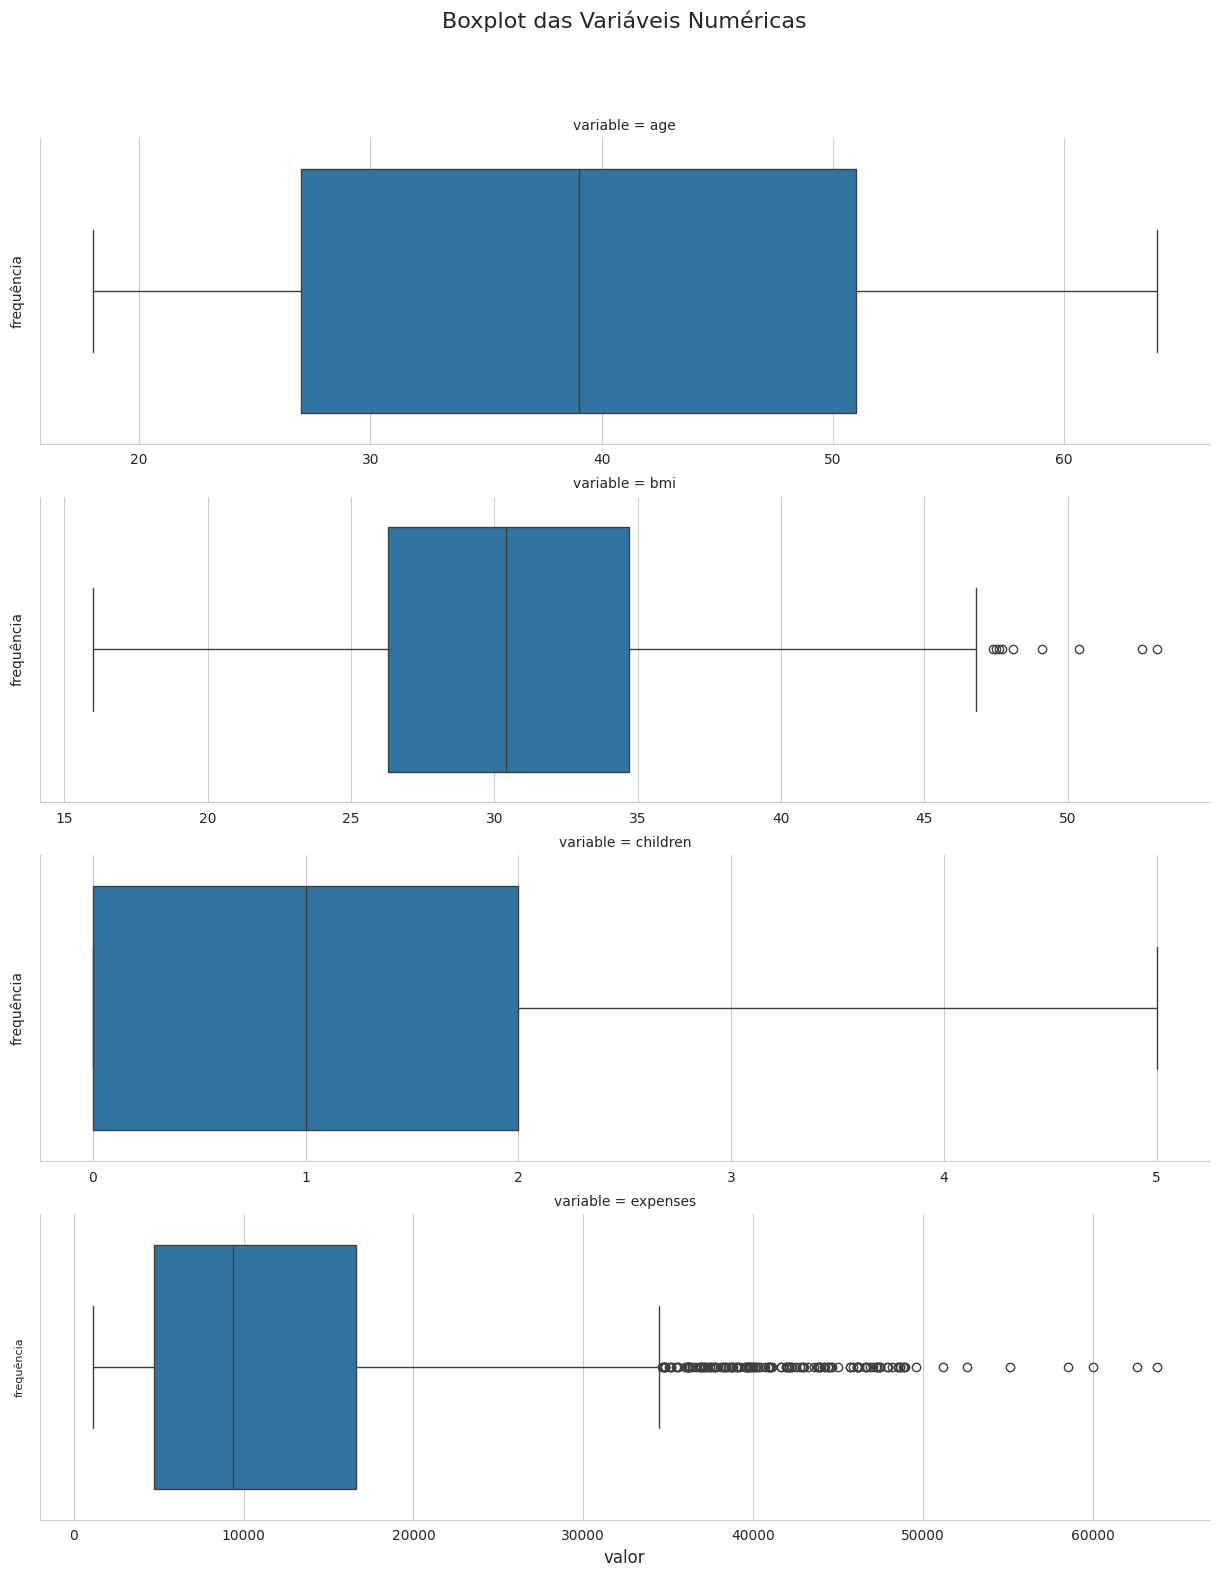

In [ ]:
df_plot = pd.melt(df, id_vars=categorical_columns, value_vars=numerical_columns)

grid = sns.FacetGrid(data=df_plot, col='variable', col_wrap=1, sharex=False, sharey=False, height=4, aspect=3)
grid.map(sns.boxplot, 'value')

ax = plt.gca()
ax.xaxis.label.set_size(12)
ax.yaxis.label.set_size(8)

grid.set_axis_labels('valor', 'frequência')
plt.subplots_adjust(top=0.9)
grid.fig.suptitle('Boxplot das Variáveis Numéricas', fontsize=16)
plt.show()

- <font color='green'><b>Age (idade): apresenta uma distribuição simétrica, sem outliers significativos.</b></font>
- <font color='green'><b>Bmi (despesas): alguns outliers altos, mediana próxima de 30</b></font>
- <font color='green'><b>Children (filhos): predomínio de 0-2 filhos, outliers para 4-5 filhos..</b></font>
- <font color='green'><b>Expenses (despesas): muitos outliers altos.</b></font>

### **Expenses**

In [ ]:
Q1 = df['expenses'].quantile(0.25)
Q3 = df['expenses'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_expenses = df[(df['expenses'] < lower_bound) | (df['expenses'] > upper_bound)]

#Printa os limites e os outliers
print(lower_bound)
print(upper_bound)

outliers_expenses.shape

-13109.15375
34489.35625


(139, 7)

<font color='green'><b>Existem 139 outliers (aproximadamente 10% da base), todos acima do limite superior.</b></font>

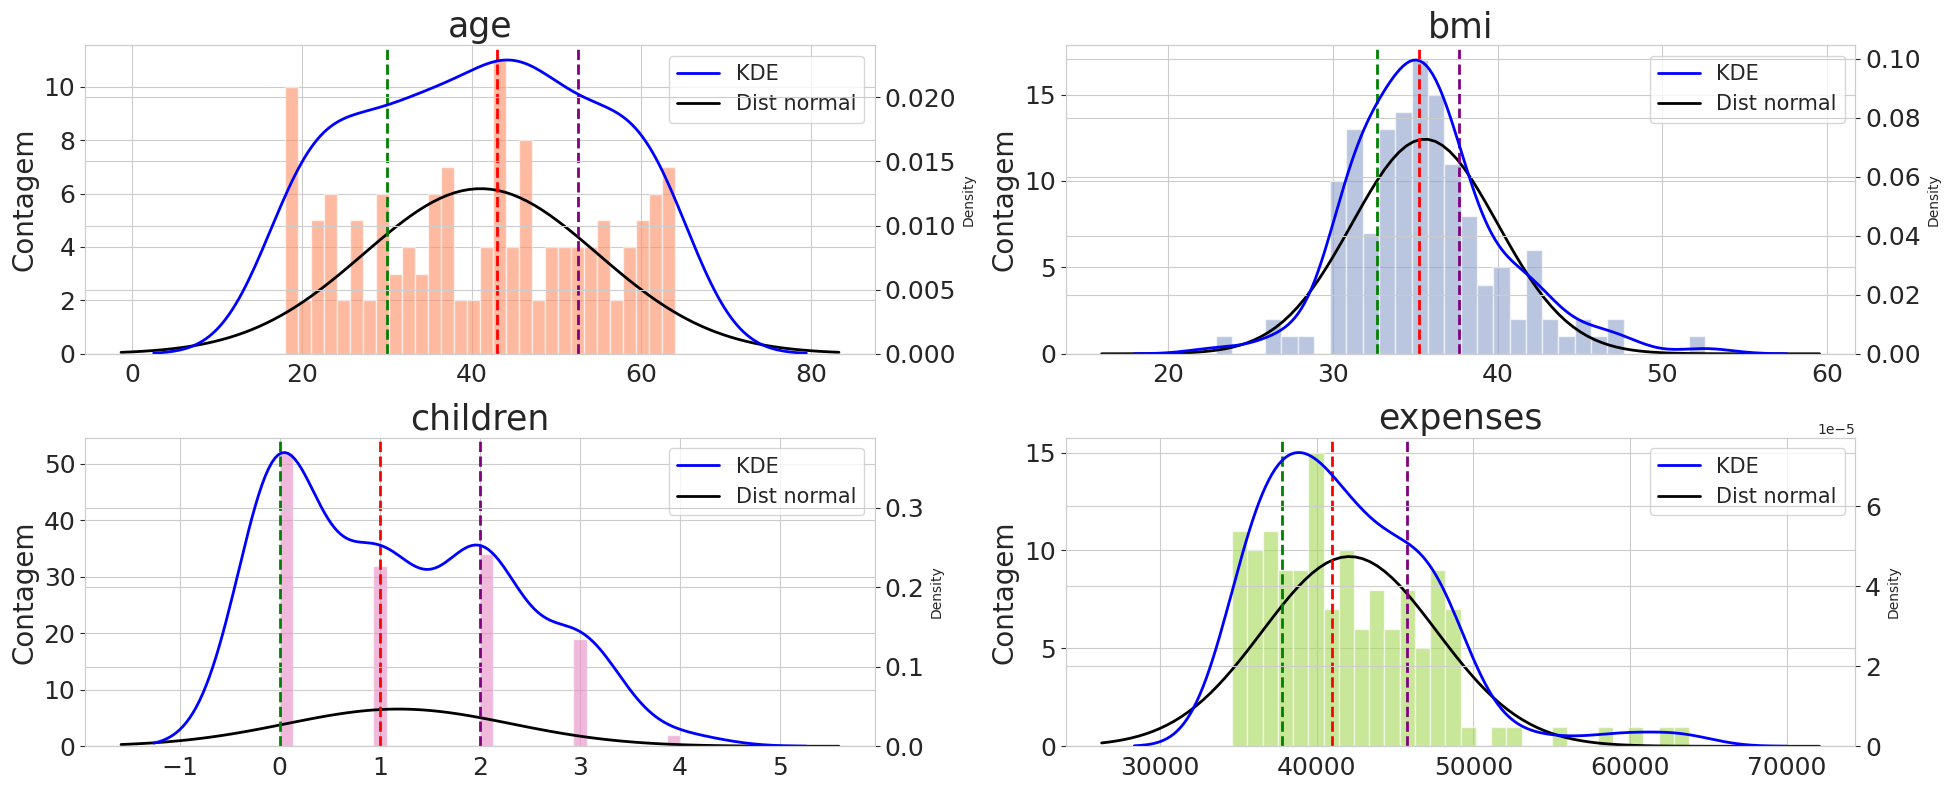

In [ ]:
sns.set_style("whitegrid")

num_cols = len(numerical_columns)
num_rows = num_cols // 3 + (num_cols % 3 > 0)

plt.figure(figsize=(5 * num_cols, 4 * num_rows))

for i, col in enumerate(numerical_columns, 1):
    ax1 = plt.subplot(num_rows, 2, i)
    data = outliers_expenses[col].dropna()

    # Histograma
    n, bins, patches = ax1.hist(data, bins=30, alpha=0.6, color=sns.color_palette("Set2")[i % len(sns.color_palette("Set2"))])
    ax1.set_ylabel('Contagem', fontsize=20)
    ax1.tick_params(axis='y', labelsize=18)

    # KDE
    ax2 = ax1.twinx()
    kde_obj = sns.kdeplot(data, ax=ax2, color='blue', linewidth=2, label='KDE')
    kde_line = kde_obj.get_lines()[0]
    ax2.tick_params(axis='y', labelsize=18)

    # Distribuição normal
    mean, std = stats.norm.fit(data)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    bin_width = np.diff(bins)[0]
    scale = len(data) * bin_width
    p = stats.norm.pdf(x, mean, std) * scale
    normal_line, = ax1.plot(x, p, 'k', linewidth=2, label='Dist normal')

    # Plot dos quartis
    q1, median, q3 = np.percentile(data, [25, 50, 75])
    ax1.axvline(q1, color='green', linestyle='dashed', linewidth=2)
    ax1.axvline(median, color='red', linestyle='dashed', linewidth=2)
    ax1.axvline(q3, color='purple', linestyle='dashed', linewidth=2)

    ax1.set_title(col, fontsize=25)
    ax1.tick_params(axis='x', labelsize=18)

    # Legendas
    lines = [kde_line, normal_line]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, fontsize=15, loc='upper right')

plt.tight_layout()
plt.show()

Verificando se as variáveis compartilham os mesmos outliers

### **BMI**

In [ ]:
Q1 = df['bmi'].quantile(0.25)
Q3 = df['bmi'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_bmi = df[(df['bmi'] < lower_bound) | (df['bmi'] > upper_bound)]
print(lower_bound)
print(upper_bound)

outliers_bmi.shape

13.699999999999998
47.300000000000004


(9, 7)

In [ ]:
common_outliers = pd.merge(outliers_expenses, outliers_bmi, how='inner')
common_outliers.shape[0]/outliers_bmi.shape[0]

0.3333333333333333

Com essa análise temos que 33,33% dos outliers de **bmi** também são outliers de **expenses**. Isso pode ser explicado pelo fato de pessoas com altos IMC enfrentam mais problemas de saúde.

In [ ]:
Q1 = df['children'].quantile(0.25)
Q3 = df['children'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_children = df[(df['children'] < lower_bound) | (df['children'] > upper_bound)]
print(lower_bound)
print(upper_bound)

outliers_children.shape

-3.0
5.0


(0, 7)

## **Variáveis categóricas**

## **Correlação**

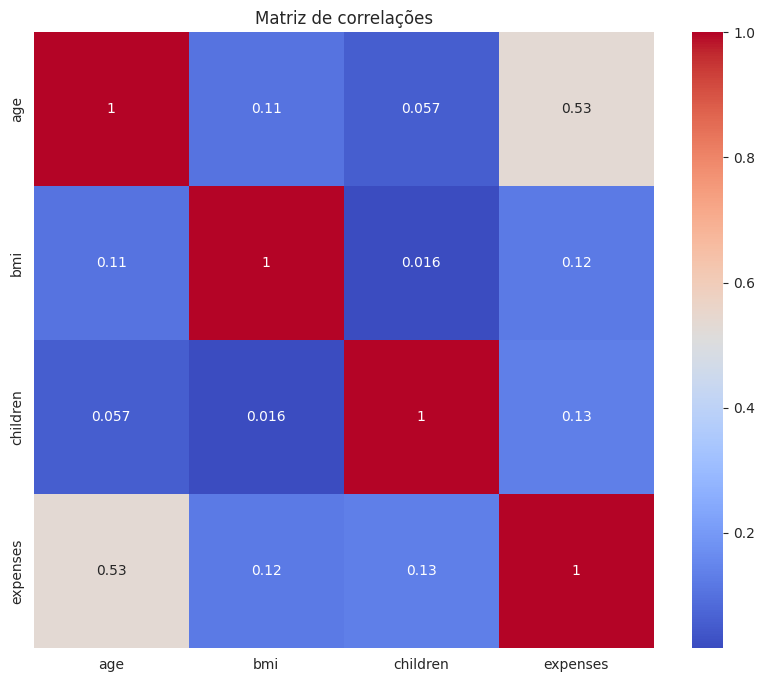

In [ ]:
plt.figure(figsize=(10, 8))

sns.heatmap(df[numerical_columns].corr(method = 'spearman'), annot=True, cmap='coolwarm')
plt.title("Matriz de correlações")
plt.show()

<font color='green'><b>As correlações são em geral baixas, exceto entre age e expenses, onde existe uma correlação moderada. Sugerindo que pessoas mais velhas possuem despesas maiores, possivelmente isso pode ser explicado por motivos de saúde.</b></font>

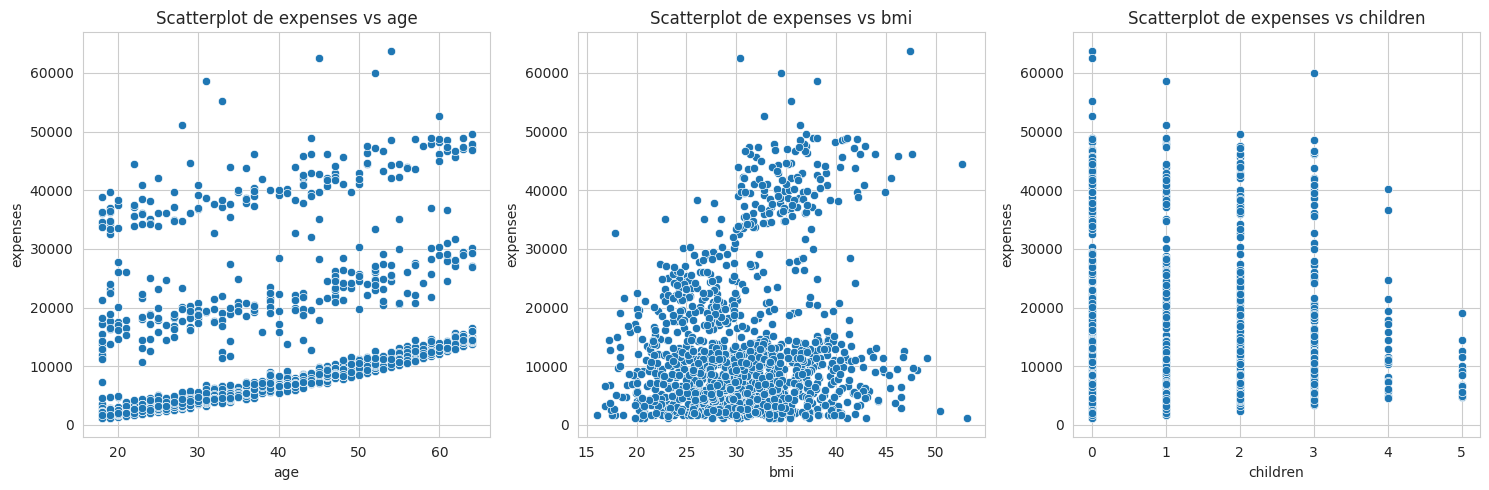

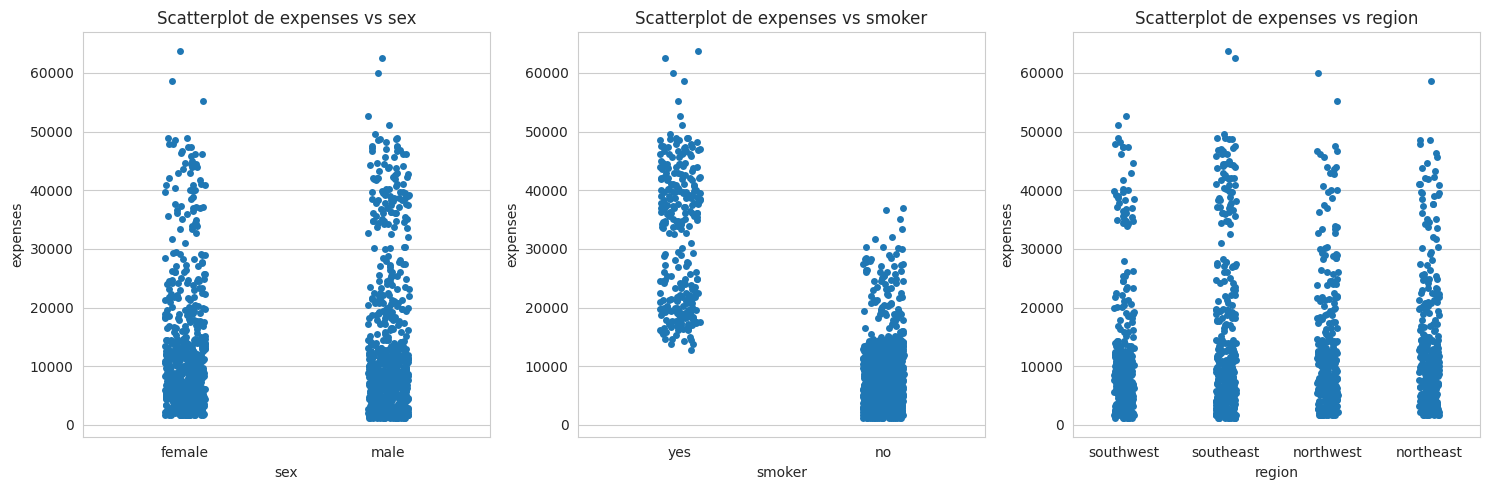

In [ ]:
target_column = 'expenses'
numerical_columns = ['age','bmi','children']

plt.figure(figsize=(15, 5))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(1, 3, i)
    sns.scatterplot(data=df, x=col, y=target_column)
    plt.title(f'Scatterplot de {target_column} vs {col}')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15, 5))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(1, 3, i)
    sns.stripplot(data=df, x=col, y=target_column, jitter=True)
    plt.title(f'Scatterplot de {target_column} vs {col}')
plt.tight_layout()
plt.show()

numerical_columns = ['age','bmi','children','expenses']

<font color='green'><b>O gráfico age vs expenses sugere três grupos de classificação: baixas despesas (abaixo de 10.000), despesas moderadas (entre 10.000 e 30.000) e altas despesas (maiores que 30.000).

Além disso, smokers têm despesas substancialmente mais altas, indicando um forte impacto do hábito de fumar nas despesas.</b></font>

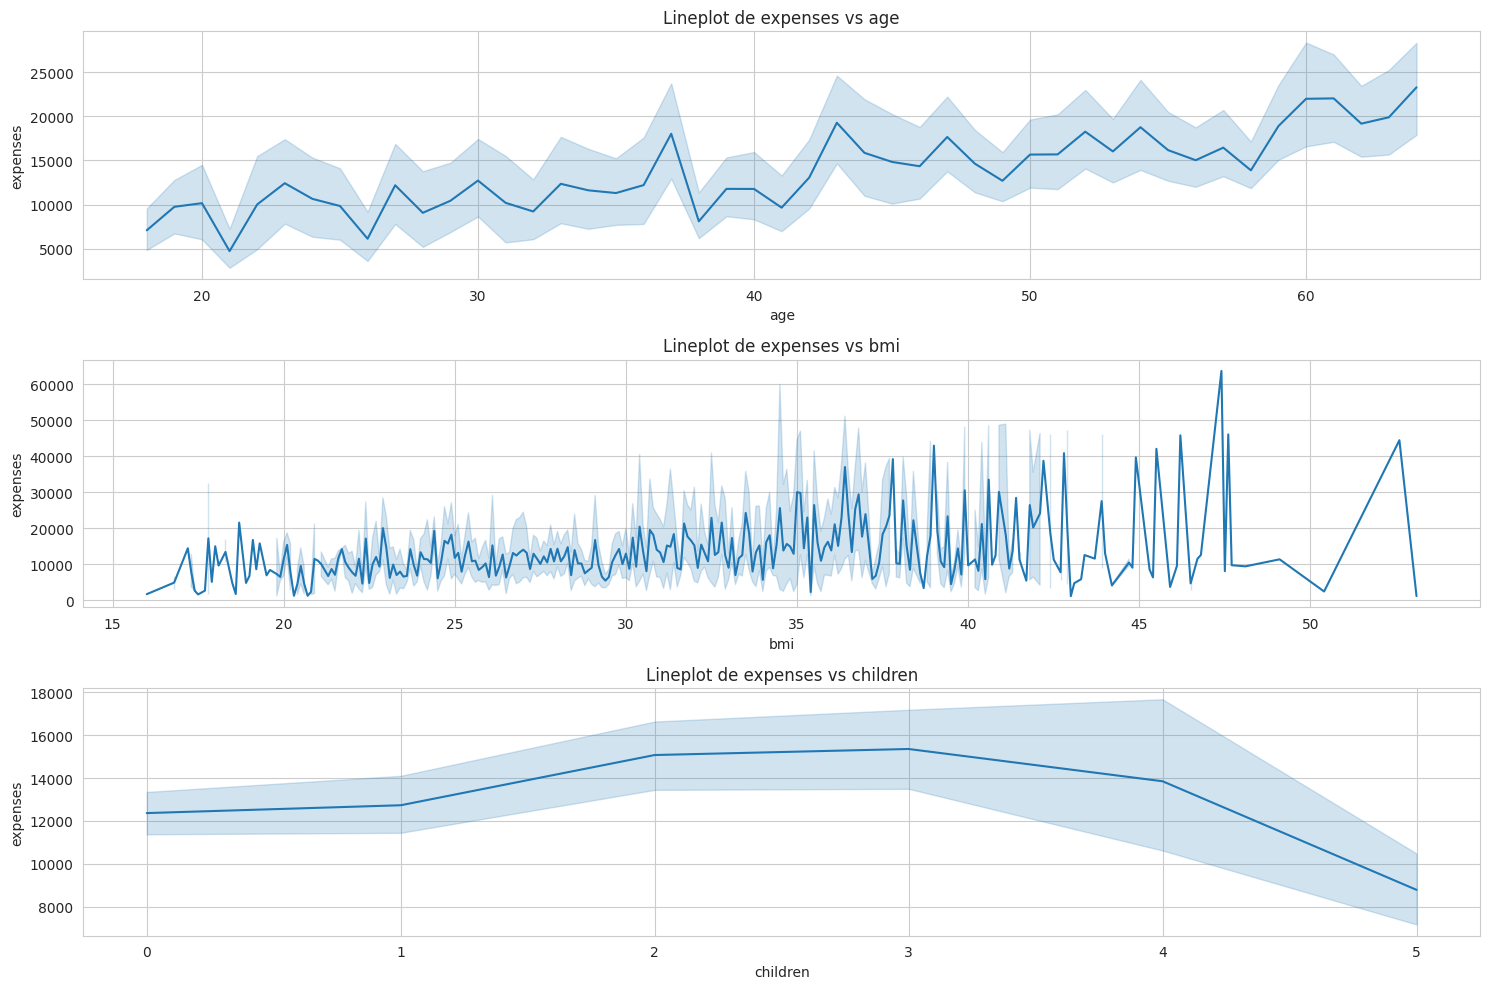

In [ ]:
variables = ['age', 'bmi', 'children']

plt.figure(figsize=(15, 5 * num_rows))

for i, col in enumerate(variables, 1):
    plt.subplot(3, 1, i)
    sns.lineplot(data=df, x=col, y=target_column)
    plt.title(f'Lineplot de {target_column} vs {col}')

plt.tight_layout()
plt.show()

<font color='green'><b>Esse gráfico de linha de age vs expanses reforça melhor as suspseitas de que os gastos aumentam conforme a idade.</b></font>

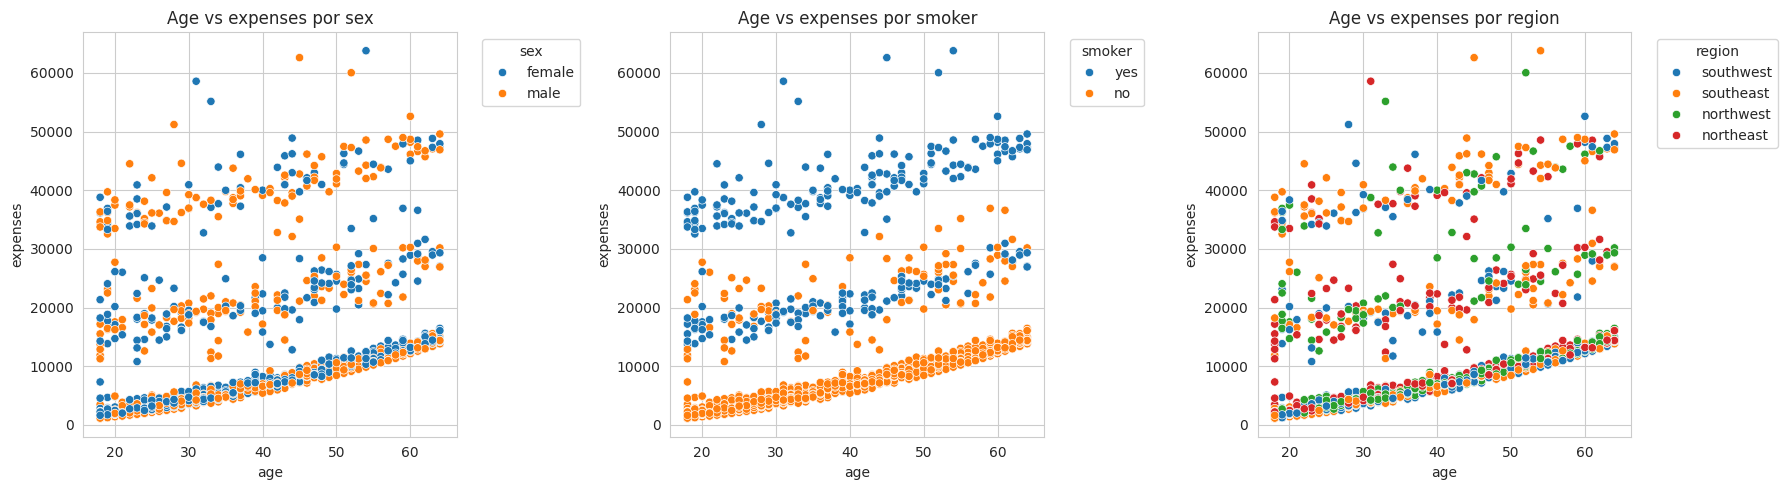

In [ ]:
plt.figure(figsize=(18, 5))

for i, cat in enumerate(categorical_columns, 1):
    plt.subplot(1, len(categorical_columns), i)
    sns.scatterplot(data=df, x='age', y=target_column, hue=cat)
    plt.title(f'Age vs {target_column} por {cat}')
    plt.legend(title=cat, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

<font color='green'><b>Com esse gráfico fica visível a relação entre fumantes e os gastos.</b></font>

In [ ]:
df.shape

(1338, 7)

## **Conclusões iniciais**

**- Distribuição das Variáveis Numéricas:**
 - BMI segue uma distribuição próxima do normal.
 - Expenses apresenta forte tendência central com muitos outliers.

**- Análise de Outliers:**
 - 10% das despesas são outliers, todos acima do limite superior.
 - 33,33% dos outliers de BMI também são outliers de expenses, possivelmente devido a problemas de saúde.

**- Correlação:**
 - As correlações entre variáveis são, em geral, baixas.
 - Correlação moderada entre age e expenses, sugerindo que pessoas mais velhas têm despesas maiores, possivelmente devido a questões de saúde.

**- Grupos de Despesas:**
 - Gráfico age vs expenses indica três grupos: baixas, moderadas e altas despesas.

**- Impacto do Tabagismo:**
 - Fumantes têm despesas substancialmente mais altas, evidenciando o impacto significativo do hábito de fumar nos custos.

**- Oportunidades de Modelagem:**
 - Insights obtidos podem orientar modelagens para identificar grupos de maior risco e prever despesas com mais precisão.

# **Pré-processamento**
*   Remoção dos outliers
*   Normalização das variáveis numéricas
*   Transformar variáveis categóricas em códigos
*   Separação entre treino e teste

## **Outliers (IQR)**

In [ ]:
Q1 = df['expenses'].quantile(0.25)
Q3 = df['expenses'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_prep = df.copy()
df_prep = df_prep[(df_prep['expenses'] >= lower_bound) & (df_prep['expenses'] <= upper_bound)]

## **Normalização**

In [ ]:
numerical_columns = ['age', 'bmi', 'children']
scaler = StandardScaler()
df_prep[numerical_columns] = scaler.fit_transform(df_prep[numerical_columns])

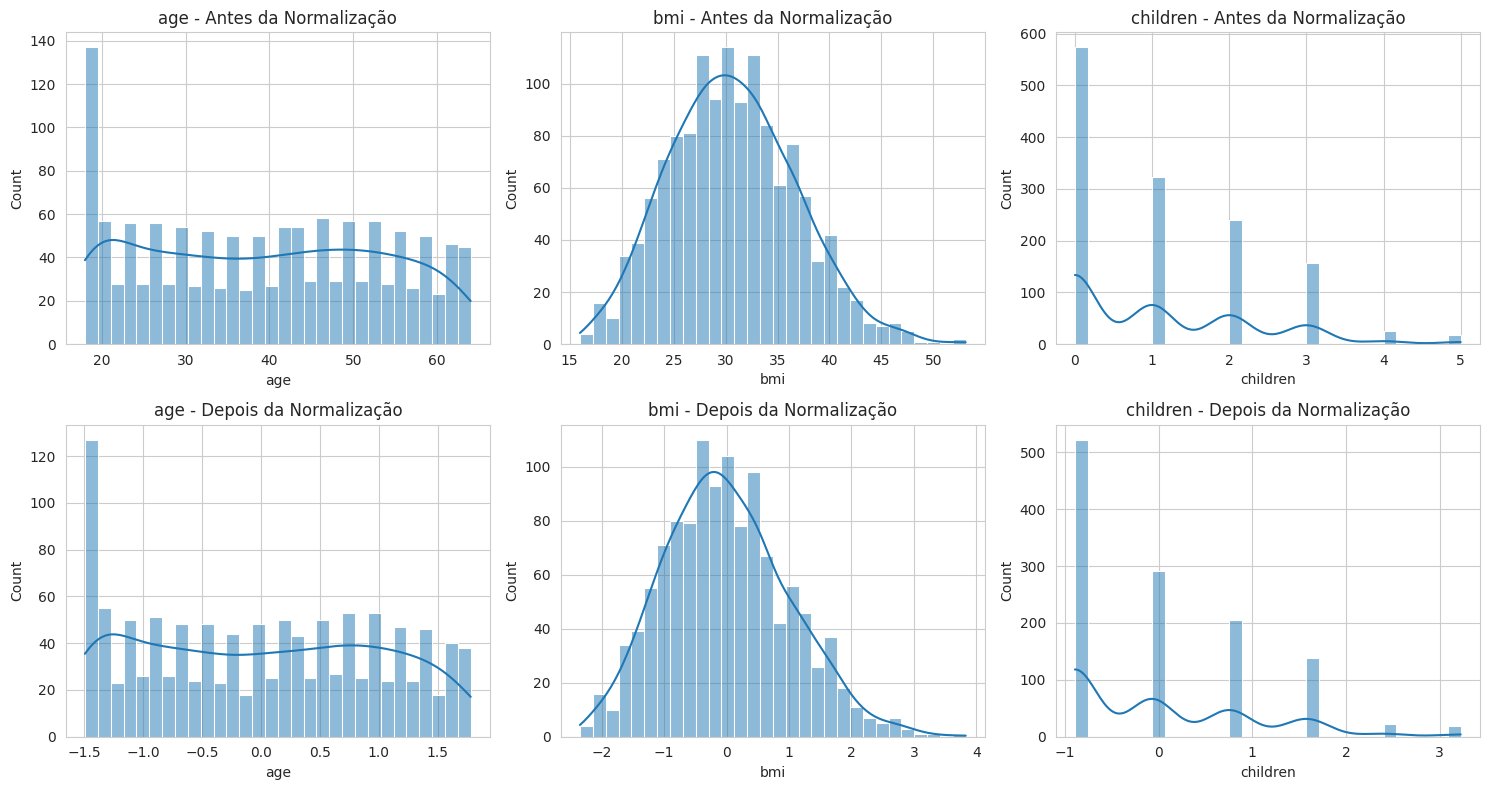

In [ ]:
fig, axes = plt.subplots(2, len(numerical_columns), figsize=(15, 8))

for i, col in enumerate(numerical_columns):
    # Antes da normalização
    sns.histplot(df[col], bins=30, ax=axes[0, i], kde=True)
    axes[0, i].set_title(f'{col} - Antes da Normalização')

    # Depois da normalização
    sns.histplot(df_prep[col], bins=30, ax=axes[1, i], kde=True)
    axes[1, i].set_title(f'{col} - Depois da Normalização')

plt.tight_layout()
plt.show()

## **Codificação**

In [ ]:
categorical_columns = ['sex', 'smoker', 'region']

df_prep['sex'] = df_prep['sex'].map({'female': 0, 'male': 1})
df_prep['smoker'] = df_prep['smoker'].map({'no': 0, 'yes': 1})

le = LabelEncoder()
df_prep['region'] = le.fit_transform(df_prep['region'])

print(df_prep.head())

   age  sex   bmi  children  smoker  region  expenses
0   19    0  27.9         0       1       3  16884.92
1   18    1  33.8         1       0       2   1725.55
2   28    1  33.0         3       0       2   4449.46
3   33    1  22.7         0       0       1  21984.47
4   32    1  28.9         0       0       1   3866.86


In [ ]:
df_prep.head()

,age,bmi,children,expenses,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.421544,-0.365636,-0.893260,16884.92,False,True,False,False,True
1,-1.492656,0.616460,-0.069399,1725.55,True,False,False,True,False
2,-0.781529,0.483295,1.578322,4449.46,True,False,False,True,False
3,-0.425965,-1.231213,-0.893260,21984.47,True,False,True,False,False
4,-0.497078,-0.199179,-0.893260,3866.86,True,False,True,False,False


In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler,OneHotEncoder

ohe = OneHotEncoder()
ohe.fit(df_prep[categorical_columns])

encoded = ohe.transform(df_prep[categorical_columns]).toarray()
df_encoded = pd.concat([df_prep.drop(categorical_columns, axis=1), pd.DataFrame(encoded)], axis=1)

df_encoded.head()

,age,bmi,children,expenses,0,1,2,3,4,5,6,7
0,19.0,27.9,0.0,16884.92,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.8,1.0,1725.55,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.0,3.0,4449.46,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.7,0.0,21984.47,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.9,0.0,3866.86,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
